In [1]:
from eodag import EODataAccessGateway, setup_logging
import pprint
import shutil
import os
import numpy as np
from osgeo import gdal, gdal_array, ogr, osr
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import folium
from rasterio.transform import from_origin
from sklearn.cluster import KMeans


In [2]:

# Define a function to download images from the provided date range
def download_images(start_date, end_date):
    setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

    dag = EODataAccessGateway()
    geometry = "POLYGON ((8.863744 36.913785, 8.864516 36.911246, 8.868205 36.912412, 8.86769 36.914951, 8.863744 36.913785))"
    search_results, total_count = dag.search(
        productType="S2_MSI_L1C",
        geom=geometry,
        start=start_date,
        end=end_date,
        cloudCover=4,
    )

    products_to_download = search_results[:2]  # Download 2 images, change as needed
    paths = dag.download_all(products_to_download)
    for file_path in paths:
        destination_path = os.path.join(
            "sentinel2", os.path.basename(file_path)
        )
        shutil.move(file_path, destination_path)

# Download images for the specified date ranges
date_ranges = [
    ("2022-01-20", "2022-02-23"),
    ("2023-11-13", "2023-11-15")
]

for start_date, end_date in date_ranges:
    download_images(start_date, end_date)


Downloaded products:   0%|          | 0/1 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

Downloaded products:   0%|          | 0/1 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

Error: Destination path 'sentinel2/S2B_MSIL1C_20231114T101159_N0509_R022_T32SMF_20231114T121436/S2B_MSIL1C_20231114T101159_N0509_R022_T32SMF_20231114T121436' already exists

In [2]:
product_paths = [
    ('sentinel2/T32SMF_20231114T101159_B02.jp2',
     'sentinel2/T32SMF_20231114T101159_B03.jp2'),
    ('sentinel2/T32SMF_20231114T101159_B04.jp2',
     'sentinel2/T32SMF_20231114T101159_B08.jp2')
]


In [3]:
for product_IR, product_red in product_paths:
    with rasterio.open(product_IR) as src:
        b8 = src.read(1) 

    with rasterio.open(product_red) as src:
        b4 = src.read(1) 
        
b4 = (b4 - np.percentile(b4, 2) )/ (np.percentile(b4, 98) - np.percentile(b4, 2) )
b8 = (b8 - np.percentile(b8, 2) )/ (np.percentile(b8, 98) - np.percentile(b8, 2) )

In [4]:

# Calculate NDVI
ndvi = (b8 - b4) / (b8 + b4)

# Calculate EVI

evi = 2.5 * ((b8 - b4) / (b8 + 6 * b4 - 7.5 * b4 + 1))
# Calculate SAVI
L = 0.5  # L factor, default value
savi = ((b8 - b4) / (b8+ b4 + L)) * (1 + L)

/tmp/ipykernel_16022/4160351601.py:2: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (b8 - b4) / (b8 + b4)


In [5]:
#composite_index = (ndvi1 * weight_ndvi) + (savi1 * weight_savi) + (evi1 * weight_evi)
composite_index = (ndvi + savi + evi)/3

composite_index.shape

(10980, 10980)

/tmp/ipykernel_4169/970435667.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  change_map = np.zeros_like(composite_index, dtype=np.float)


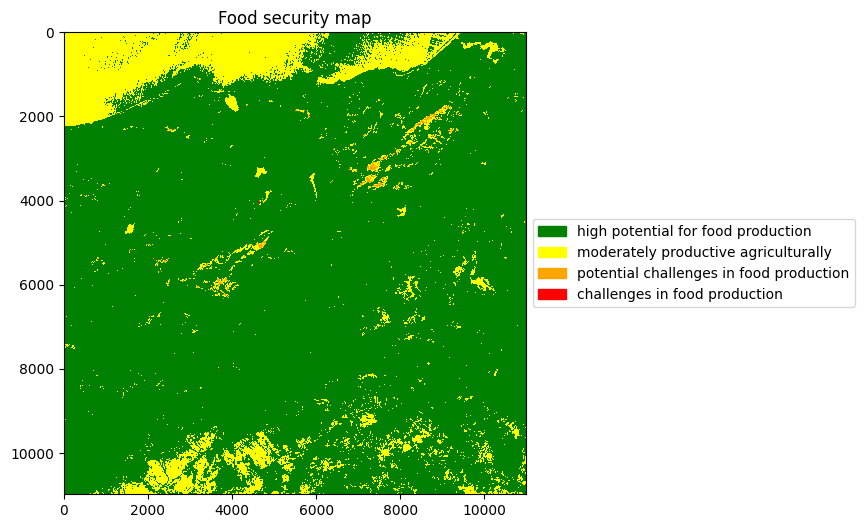

In [24]:
# Define the thresholds for categorization
thresholds = {
    'high potential for food production': [-2, 0],
    'moderately productive agriculturally': [0, 1],
    'potential challenges in food production': [1, 2],
    'challenges in food production': [3, np.inf]  # Values greater than 3
}

# Define colors for each label
colors = {
    'high potential for food production': 'green',
    'moderately productive agriculturally': 'yellow',
    'potential challenges in food production': 'orange',
    'challenges in food production': 'red'
}

# Create an empty array for the categorized labels
change_map = np.zeros_like(composite_index, dtype=np.float)

# Assign labels based on the thresholds
for label, (lower, upper) in thresholds.items():
    change_map[(composite_index >= lower) & (composite_index < upper)] = list(thresholds.keys()).index(label)

# Create a colormap with specified colors
cmap = ListedColormap([colors[label] for label in thresholds.keys()])

# Plot the results with labels and legend
plt.figure(figsize=(8, 6))
plt.imshow(change_map, cmap=cmap)  # Reshape if the array is 1D


# Create a legend outside the map
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in thresholds.keys()]
plt.legend(handles, thresholds.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Food security map')
plt.show()
